<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Implementation/Pipeline/Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results collection

This notebook collects and presents the results of the experiments.

## Preliminaries

In [1]:
# Parameters for results calculation.
n_bootstrap = 100   # Number of bootstrapped samples to take.
seeds = [2^i for i in range(n_bootstrap)]   # For reproducability in resampling.
threshold_tIoU = 0.25   # Threshold t-IoU to consider a timeframe correctly predicted.

# Selecting which models to display a ROC curve for.
roc_datasets = ['fishClips', 'AK-fish']
roc_frameSelections = ['motionAbsdiff_10']
roc_models = ['dinov2-vitg14-clf', 'dinov2-vitg14-reg-clf']
roc_imageSizes = [448]
roc_classifiers = ['ShallowNetwork']
roc_valScores = ['roc-auc']

In [2]:
# Specifying directories where the results are stored.
parameters_drive_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Results/Parameters'    # Best model parameters
predictions_drive_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Results/Predictions'  # Predictions for test set

In [3]:
# Mount Drive.
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Copy results to runtime if they have not been already.
import os
import shutil

parameters_dir = '/content/Parameters'
predictions_dir = '/content/Predictions'

if not os.path.exists(parameters_dir):
  shutil.copytree(parameters_drive_dir, parameters_dir)

if not os.path.exists(predictions_dir):
  shutil.copytree(predictions_drive_dir, predictions_dir)

In [5]:
# Dictionaries for later ease of use.
dataset_dict = {'fishClips' : 'Coral reef', 'AK-fish' : 'AK fish'}
frameSelection_dict = {'evenly' : 'Evenly spaced', 'motionAbsdiff' : 'Motion-based'}

## Collect AR results
Collect the results of the Action Recognition task.

In [6]:
# Update sklearn version as at least 1.3 is needed.
! pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [7]:
# Functions to process AR results.
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import resample

def bootstrap_AR_metrics(data, threshold, n_bootstrap=100, sample_size=50, \
                      seeds=None):
    """
    Calculation of performance metrics based on bootstrapped test samples.
    :param: data: a dataframe containing predictions.
                  Must contain columns 'prediction' and 'label'.
    :param: threshold: the threshold to use for positive predictions.
    :param: n_bootstrap: the number of bootstrapping rounds.
    :param: sample_size: the size of one bootstrapped sample.
    :param: seed: random state for reproducability.
    :return: a dictionary containing the accuracy, recall, precision and their standard deviations.
    """
    accuracy_scores = []
    recall_scores = []
    precision_scores = []

    if seeds is None:
      seeds = [i for i in range(n_bootstrap)]

    current_sample_idx = 0

    trials = 0

    # Collect n_bootstrap number of metrics.
    while len(accuracy_scores) < n_bootstrap:
        seed = seeds[current_sample_idx] + trials

        # Resample the data with replacement
        sample = resample(data, n_samples=sample_size, random_state=seed)

        # Convert probabilities to binary predictions based on threshold
        predictions = (sample['prediction'] >= threshold).astype(int)
        true_values = sample['label']

        # Only calculate metrics if there is at least 1 positive label in the
        # sample and 1 positive prediction.
        if sum(predictions) > 1 and sum(true_values) > 1:
          accuracy_scores.append(accuracy_score(true_values, predictions))
          recall_scores.append(recall_score(true_values, predictions))
          precision_scores.append(precision_score(true_values, predictions))

          current_sample_idx += 1

          trials = 0

        # Otherwise, try with new seed.
        else:
          trials += 1

    return {
        'accuracy': (np.mean(accuracy_scores), np.std(accuracy_scores)),
        'recall': (np.mean(recall_scores), np.std(recall_scores)),
        'precision': (np.mean(precision_scores), np.std(precision_scores))
    }

In [9]:
# Collect AR results.

results = []

for pred_file in os.listdir(predictions_dir):

  # Consider only prediction outputs files and ignore ones related to the AK sample.
  # (As these are used in other types of analysis.)
  if pred_file.startswith('pred') and 'AK-sample' not in pred_file:
    predictions = pd.read_csv(f'{predictions_dir}/{pred_file}')

  else:
    continue

  # Read the setup of the experiment.
  properties = pred_file.split('_')

  dataset = dataset_dict[properties[1]]
  frame_selection = frameSelection_dict[properties[2]]

  if 'VideoMAE' in pred_file:   # If it is a benchmarking result.
    model_name = properties[4]

    registers = '-'

  elif 'videomae' not in pred_file:   # Ignore results with 'videomae' in the name as those are from experiments not used in the analysis.
    model_properties = '-'.join(properties[4].split('-')[:3])

    registers = 'reg' in model_properties

    model_name = 'MARINE'

    if 's14' in model_properties:
      model_name += ' S14'

    elif 'g14' in model_properties:
      model_name += ' G14'

  # Read threshold for positive predictions.
  params_file = pred_file.replace('pred_', 'params_')
  parameters = pd.read_csv(f'{parameters_dir}/{params_file}')

  pos_threshold = parameters['pos_threshold'][0]

  # Set size of one bootstrapped sample to the size of the prediction set.
  sample_size = len(predictions)

  # Calculate performance metrics based on bootstrapped sample.
  metrics = bootstrap_AR_metrics(predictions, pos_threshold, \
                              n_bootstrap, sample_size, seeds)

  results.append({
    'Dataset' : dataset,
    'Frame selection' : frame_selection,
    'Model' : model_name,
    'Registers' : registers,
    'Accuracy': f'{metrics["accuracy"][0] * 100:.2f} +/ {1.96 * metrics["accuracy"][1] * 100:.2f} %',
    'Recall': f'{metrics["recall"][0] * 100:.2f} +/ {1.96 * metrics["recall"][1] * 100:.2f} %',
    'Precision': f'{metrics["precision"][0] * 100:.2f} +/ {1.96 * metrics["precision"][1] * 100:.2f} %',
    })

results_df = pd.DataFrame(results)

# Sort dataframe.
results_df = results_df.sort_values(by=['Dataset', 'Frame selection', \
                                        'Model', 'Registers'], \
                                    ascending=[False, True, True, True])

# Reset index.
results_df.reset_index(inplace=True, drop=True)

In [10]:
# Show the results table.
results_df

,Dataset,Frame selection,Model,Registers,Accuracy,Recall,Precision
0,Coral reef,Evenly spaced,MARINE G14,False,23.71 +/ 12.53 %,100.00 +/ 0.00 %,20.35 +/ 12.70 %
1,Coral reef,Evenly spaced,MARINE G14,True,25.69 +/ 12.87 %,100.00 +/ 0.00 %,20.78 +/ 13.00 %
2,Coral reef,Evenly spaced,MARINE S14,False,19.51 +/ 12.25 %,100.00 +/ 0.00 %,19.51 +/ 12.25 %
3,Coral reef,Evenly spaced,MARINE S14,True,36.89 +/ 15.29 %,100.00 +/ 0.00 %,23.63 +/ 14.45 %
4,Coral reef,Evenly spaced,VideoMAE,-,67.60 +/ 13.03 %,53.16 +/ 36.66 %,31.07 +/ 25.46 %
5,Coral reef,Motion-based,MARINE G14,False,81.53 +/ 10.36 %,52.52 +/ 33.77 %,53.01 +/ 37.24 %
6,Coral reef,Motion-based,MARINE G14,True,73.71 +/ 14.31 %,44.62 +/ 37.35 %,36.06 +/ 33.34 %
7,Coral reef,Motion-based,MARINE S14,False,33.16 +/ 13.93 %,88.01 +/ 22.57 %,20.99 +/ 13.77 %
8,Coral reef,Motion-based,MARINE S14,False,19.51 +/ 12.25 %,100.00 +/ 0.00 %,19.51 +/ 12.25 %
9,Coral reef,Motion-based,MARINE S14,True,19.51 +/ 12.25 %,100.00 +/ 0.00 %,19.51 +/ 12.25 %


In [11]:
# Save results table to Drive.
drive_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Results/Metrics'

if not os.path.exists(drive_dir):
  os.makedirs(drive_dir)

from datetime import datetime
current_date = datetime.now().strftime('%d-%m-%Y')

results_df.to_csv(f'{drive_dir}/AR_results_{current_date}.csv', index=False)

## ROC curve
Display ROC curves for the selected models.

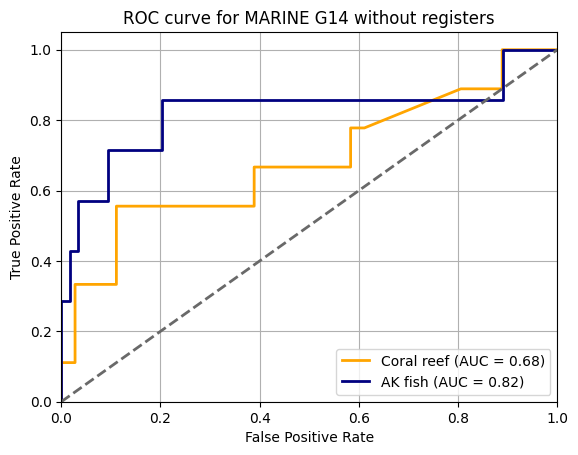

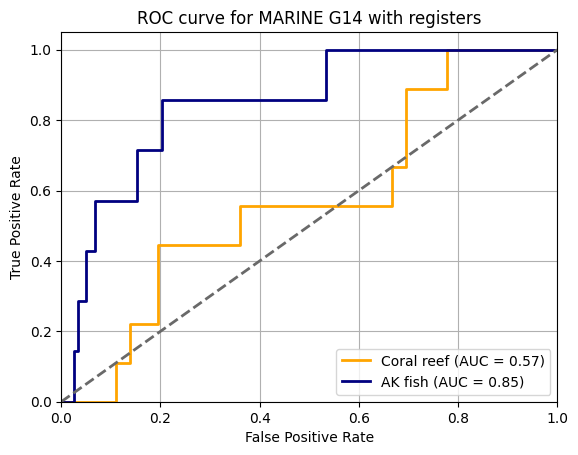

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for model in roc_models:
  # Initialize dictionary to hold all data for curves.
  curves_data = {}

  has_registers = 'with' if 'reg' in model else 'without'

  if 'g14' in model:
    model_name = 'MARINE G14'

  elif 's14' in model:
    model_name = 'MARINE S14'

  for dataset in roc_datasets:
    for frame_selection in roc_frameSelections:
      for image_size in roc_imageSizes:
        for classifier in roc_classifiers:
          for val_score in roc_valScores:

            dataset_name = dataset_dict[dataset]

            curves_data[dataset_name] = {}

            pred_file = f'pred_{dataset}_{frame_selection}_{model}_{image_size}_{classifier}_{val_score}.csv'

            pred_data = pd.read_csv(f'{predictions_dir}/{pred_file}')

            predictions = pred_data['prediction']
            true_labels = pred_data['label']

            # Compute the ROC curve values
            fpr, tpr, thresholds = roc_curve(true_labels, predictions)

            # Compute the AUC (Area Under the Curve)
            roc_auc = auc(fpr, tpr)

            # Add data to dictionary
            curves_data[dataset_name]['fpr'] = fpr
            curves_data[dataset_name]['tpr'] = tpr
            curves_data[dataset_name]['thresholds'] = thresholds
            curves_data[dataset_name]['auc'] = roc_auc

  # Plot the ROC curve
  plt.figure()

  for dataset, curve_data in curves_data.items():
    if dataset == 'Coral reef':
      color = 'orange'

    elif dataset == 'AK fish':
      color = 'navy'

    plt.plot(curve_data['fpr'], curve_data['tpr'], color=color, lw=2, label=f'{dataset} (AUC = {curve_data["auc"]:.2f})')


  plt.plot([0, 1], [0, 1], color='dimgrey', lw=2, linestyle='--')  # Diagonal line
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC curve for {model_name} {has_registers} registers')
  plt.legend(loc='lower right')
  plt.grid(True)

  # Save figure to Drive.
  figures_dir = f"/content/drive/My Drive/UvA/M Thesis/Data/Results/Figures/"

  if not os.path.exists(figures_dir):
      os.makedirs(figures_dir)

  figure_path = os.path.join(figures_dir, f'ROC_{model}.png')

  plt.savefig(figure_path, dpi=300, bbox_inches='tight')
  plt.show()

## AD task results
Calculating average precision based on t-IoU for temporal action detection.

In [ ]:
## FUNCTIONS FOR COLLECTING RESULTS

def check_correct_AD(video_preds, threshold=0.5):
  ''' Collects the predicted action timeframes and whether they are correct
  based on a t-IoU of over 50%.
  :param: video_preds: a dataframe containing the predictions for each clip
    in an untrimmed video.
  :param: threshold: the threshold for positive predictions.
  :returns: a list of Boolean values, where True is for a correct prediction
    and False is for incorrect.
  '''

  # The binary predictions based on the provided threshold.
  predictions = list((video_preds['prediction'] >= threshold).astype(int))

  # The length of the true action in number of frames.
  # Assumes that there is only a single action clip included per video.
  length_true_action = 1

  positive_predictions_list = []

  # Create list of [start_index, length] sublists indicating the start index
  # and length of each predicted action.
  for i, prediction in enumerate(predictions):
    # If an action is predicted.
    if prediction == 1:
      if predictions[i - 1] != 1 or i == 0:
        positive_predictions_list.append([i])

      if i == len(predictions) - 1:
        previous_start = positive_predictions_list[-1][0]
        positive_predictions_list[-1].append(i - previous_start + 1)

    # If no action is predicted but there has been one before.
    elif len(positive_predictions_list) > 0:
      # If this is the first non-action predicted frame after a predicted action.
      if len(positive_predictions_list[-1]) < 2:
        previous_start = positive_predictions_list[-1][0]
        positive_predictions_list[-1].append(i - previous_start + 1)

  prediction_correctness = []

  for prediction in positive_predictions_list:
    start, length = tuple(prediction)

    # Check if attack (i.e., the 3rd clip at index 2) is covered by the action.
    intersection = 2 in range(start, start + length)

    union = length + length_true_action - intersection

    tIoU = int(intersection) / union

    # Append correct prediction if tIoU is at least 50%, incorrect otherwise.
    prediction_correctness.append(tIoU > threshold_tIoU)

  return prediction_correctness

def bootstrap_AP(prediction_checks, n_bootstrap=100, sample_size=9, \
                      seeds=None):
    """
    Calculates mean precision on a bootstrapped sample.
    :param: prediction_checks: a list of lists, where each sublist corresponds to
      a video and contains Boolean values showing if the predicted actions were
      correct or not in that video.
    :param: n_bootstrap: the number of bootstrapping rounds.
    :param: sample_size: the size of one bootstrapped sample.
    :param: seed: random state for reproducability.
    :return: average precision with confidence intervals.
    """

    precisions = []

    for video_preds in prediction_checks:
      total_predicted = len(video_preds)

      # Only include video if there was at least one action predicted.
      if total_predicted > 0:
        correct = sum(video_preds)

        precision = correct / total_predicted

        precisions.append(precision)

    avg_precisions = []

    if seeds is None:
      seeds = [i for i in range(n_bootstrap)]

    for i in range(n_bootstrap):
        seed = seeds[i]

        # Resample the data with replacement
        sample = resample(precisions, n_samples=sample_size, random_state=seed)

        # Save average precision.
        avg_precisions.append(np.mean(sample))

    # Return mean average precision and its standard deviation.
    return np.mean(avg_precisions), np.std(avg_precisions)

In [ ]:
# Collect AD results

results = []

for pred_file in os.listdir(predictions_dir):

  # Consider only prediction outputs files for the fish video dataset.
  if pred_file.startswith('pred') and 'fishClips' in pred_file:
    predictions = pd.read_csv(f'{predictions_dir}/{pred_file}')

  else:
    continue

  # Read the setup of the experiment.
  properties = pred_file.split('_')

  dataset = dataset_dict[properties[1]]   # This will always be the fish videos.
  frame_selection = frameSelection_dict[properties[2]]

  if 'VideoMAE' in pred_file:   # If it is a benchmarking result.
    model_name = properties[4]

  else:
    model_properties = '-'.join(properties[4].split('-')[:3])

    registers = 'reg' in model_properties

    model_name = 'MARINE'

    if 's14' in model_properties:
      model_name += ' S14'

    elif 'g14' in model_properties:
      model_name += ' G14'

  # Read threshold for positive predictions.
  params_file = pred_file.replace('pred_', 'params_')
  parameters = pd.read_csv(f'{parameters_dir}/{params_file}')

  pos_threshold = parameters['pos_threshold'][0]

  # Set size of one bootstrapped sample to the number of videos in the test set.
  nr_clips_per_video = 5

  sample_size = len(predictions) // nr_clips_per_video

  # For each video, collect the number of correct action timeframes.
  preds_per_video = []

  predictions['video_id'] = predictions['video'].str.extract(r'(video\d+)', expand=False)

  grouped_predictions = predictions.groupby('video_id')

  for _, group_df in grouped_predictions:
    preds_per_video.append(check_correct_AD(group_df, pos_threshold))

  # Calculate the average precision and its standard deviation on a bootstrapped sample.
  avg_precision, std_precision = bootstrap_AP(preds_per_video, n_bootstrap, \
                                              sample_size, seeds)

  results.append({
    'Frame selection' : frame_selection,
    'Model' : model_name,
    'Registers' : registers,
    'Average precision' : f'{avg_precision * 100:.2f} %',
    'Standard deviation' : f'{std_precision * 100:.2f} %'
    })

results_df = pd.DataFrame(results)

# Sort dataframe.
results_df = results_df.sort_values(by=['Frame selection', \
                                        'Model', 'Registers'], \
                                    ascending=[True, True, True])

# Reset index.
results_df.reset_index(inplace=True, drop=True)

In [ ]:
# Show the AD results table.
results_df

,Frame selection,Model,Registers,Average precision,Standard deviation
0,Evenly spaced,MARINE G14,False,0.00 %,0.00 %
1,Evenly spaced,MARINE G14,True,11.11 %,9.94 %
2,Evenly spaced,MARINE S14,False,0.00 %,0.00 %
3,Evenly spaced,MARINE S14,True,22.00 %,13.88 %
4,Evenly spaced,VideoMAE,False,29.72 %,8.03 %
5,Motion-based,MARINE G14,False,80.78 %,12.05 %
6,Motion-based,MARINE G14,True,38.61 %,7.55 %
7,Motion-based,MARINE S14,False,0.00 %,0.00 %
8,Motion-based,MARINE S14,True,0.00 %,0.00 %
9,Motion-based,VideoMAE,True,22.00 %,13.88 %


In [ ]:
# Save results table to Drive.
drive_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Results/Action detection'

if not os.path.exists(drive_dir):
  os.makedirs(drive_dir)

from datetime import datetime
current_date = datetime.now().strftime('%d-%m-%Y')

results_df.to_csv(f'{drive_dir}/AD_results_{current_date}.csv', index=False)